## Transfer learning test - scoping out SEDE data

### Step 0: importation of stuff

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Step 1: Exploring the data

In [12]:
raw_df = read_csv("data/sede_data_5000.csv")

Rows: 13413 Columns: 8

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Tags
dbl  (6): Id, PostId, Score, UserId, ViewCount, AnswerCount
dttm (1): CreationDate


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [13]:
raw_df = mutate(raw_df, Score = as.integer(Score), ViewCount = as.integer(ViewCount), AnswerCount = as.integer(AnswerCount))

In [15]:
head(raw_df)

Id,PostId,Score,CreationDate,UserId,Tags,ViewCount,AnswerCount
<dbl>,<dbl>,<int>,<dttm>,<dbl>,<chr>,<int>,<int>
793695,985280,23,2009-06-12 06:47:41,24424,<c#><constructor>,119213,4
83388596,48203314,17,2018-01-11 09:39:16,3545273,<c++><c><language-lawyer>,2183,4
90683777,50782806,16,2018-08-15 20:16:23,4815718,<android><google-maps><google-play-services>,70338,10
14790392,11253360,15,2012-06-28 21:49:56,1267286,<memory><haskell><memory-management><recursion><callstack>,922,4
83390881,48203314,14,2018-01-11 10:34:35,3545273,<c++><c><language-lawyer>,2183,4
8612199,7174927,11,2011-08-24 11:57:04,552450,<python><sockets>,142059,3


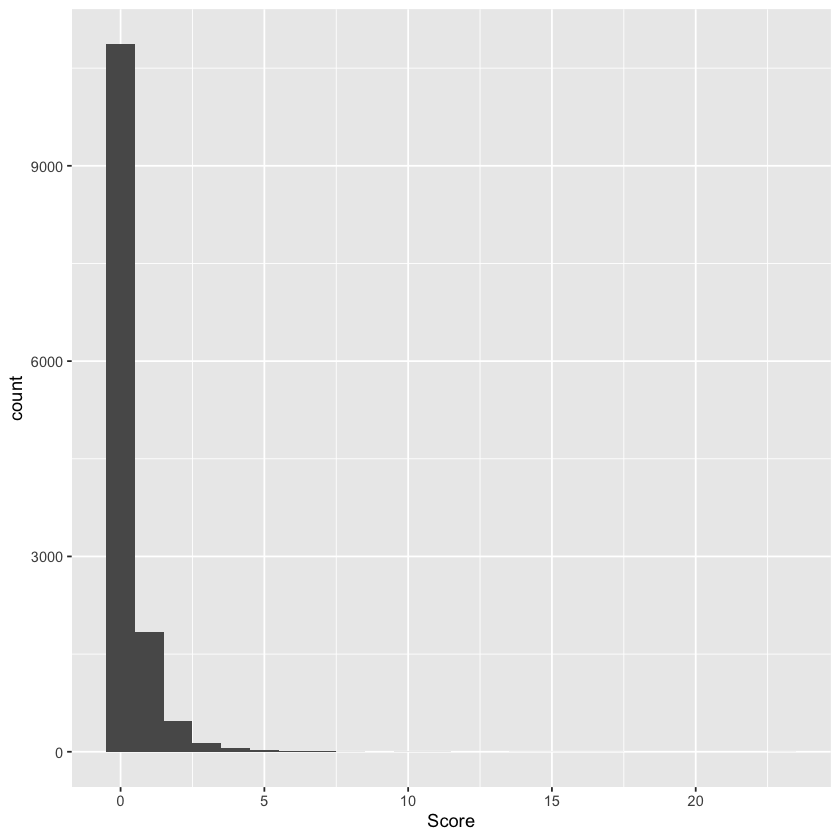

In [16]:
ggplot(raw_df, aes(x=Score)) + geom_histogram(binwidth=1)

UserId,n
<dbl>,<int>
3545273,5249
4815718,1357
2044766,368
1716356,195
10805962,173
1935631,165


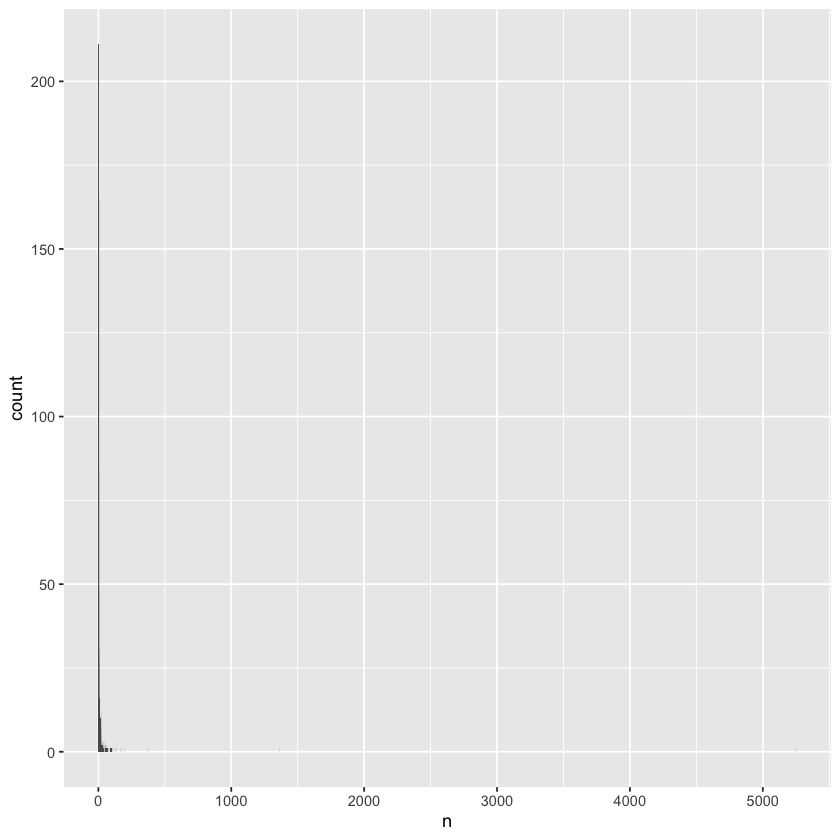

In [17]:
count_df = raw_df %>% count(UserId) %>% arrange(desc(n))

head(count_df)
ggplot(count_df, aes(x=n)) + geom_histogram(binwidth=1)

In [18]:
nrow(filter(count_df, n >= 20))

[1] 71

In [45]:
# is there a more time-efficient way to generate all tags?

tags = c()
for (i in c(1:nrow(raw_df))) {
    s = raw_df$Tags[i]
    s = as.list(strsplit(s, split="><")[[1]]) # why do I need to do this stupid syntax for full conversion
    s[1] = substring(s[1], 2)
    s[length(s)] = substring(s[length(s)],1,nchar(s[length(s)])-1)
    tags = union(tags, s)
#     print(s[1])
}
tags <- unlist(tags)

In [79]:
tags_df = data.frame(matrix(ncol=2,nrow=0))
for (i in c(1:length(tags))) {
    occurrences = nrow(filter(raw_df, grepl(paste("<",tags[i],">",sep=""), raw_df$Tags, fixed=TRUE)))
    tags_df[nrow(tags_df)+1,] = c(tags[i], occurrences)
}

In [78]:
tags_df

,X1,X2
,<chr>,<chr>
1,c#,361
2,constructor,28
3,c++,1151
4,c,925
5,language-lawyer,50
6,android,1533
7,google-maps,16
8,google-play-services,54
9,memory,46


In [80]:
head(raw_df)

Id,PostId,Score,CreationDate,UserId,Tags,ViewCount,AnswerCount
<dbl>,<dbl>,<int>,<dttm>,<dbl>,<chr>,<int>,<int>
793695,985280,23,2009-06-12 06:47:41,24424,<c#><constructor>,119213,4
83388596,48203314,17,2018-01-11 09:39:16,3545273,<c++><c><language-lawyer>,2183,4
90683777,50782806,16,2018-08-15 20:16:23,4815718,<android><google-maps><google-play-services>,70338,10
14790392,11253360,15,2012-06-28 21:49:56,1267286,<memory><haskell><memory-management><recursion><callstack>,922,4
83390881,48203314,14,2018-01-11 10:34:35,3545273,<c++><c><language-lawyer>,2183,4
8612199,7174927,11,2011-08-24 11:57:04,552450,<python><sockets>,142059,3
